# Red Wine Quality Prediction

Red Wine Quality Prediction Problem Statement: The dataset is related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

This dataset can be viewed as classification task. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Attribute Information

Input variables (based on physicochemical tests): 1 - fixed acidity 2 - volatile acidity 3 - citric acid 4 - residual sugar 5 - chlorides 6 - free sulfur dioxide 7 - total sulfur dioxide 8 - density 9 - pH 10 - sulphates 11 - alcohol Output variable (based on sensory data): 12 - quality (score between 0 and 10)

What might be an interesting thing to do, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'. This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.

You need to build a classification model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox, zscore
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import joblib
import warnings as wr
wr.filterwarnings("ignore")

In [3]:
df=pd.read_csv('Red Wine Quality Prediction.csv')
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [4]:
df.shape

(1599, 12)

There are 1599 rows and 12 columns including the target column

In [5]:
#to know missing values, data types
pd.set_option('display.max_rows', None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


There are no null values. Except target column all the columns has float datatype

In [6]:
#checking datatypes of all columns
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

It contains float and integer datatypes

In [7]:
#to know the features of the dataset
columns= df.columns
columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
#statistical summary 
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

# Exploratory Data Analysis

In [20]:
#checking the missing values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

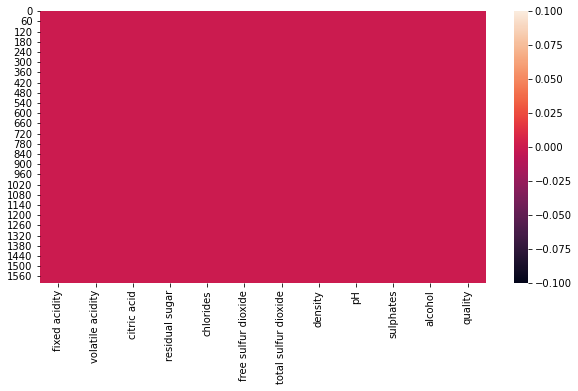

In [23]:
#Another way to check missing values
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull())
plt.show()               #visualizing missing values using heatmap

No null values in the above data

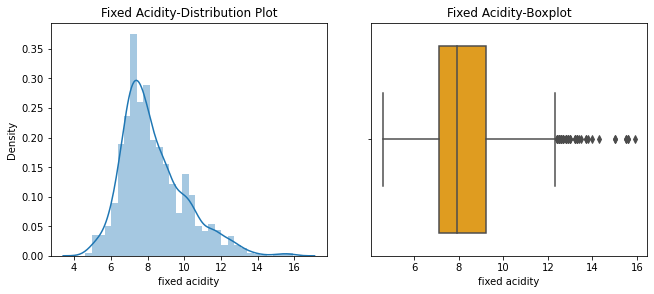

In [24]:
#visualizing fixed acidity feature by boxplot and distplot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(df['fixed acidity'])
plt.title('Fixed Acidity-Distribution Plot')

plt.subplot(1,2,2)
sns.boxplot(df['fixed acidity'], color='orange')
plt.title('Fixed Acidity-Boxplot')

plt.tight_layout(pad=4)
plt.show()

We can see outliers and also the data is skewed for the 'fixed acidity'.

## Checking Outliers:

All Features-Boxplot


<function matplotlib.pyplot.show(close=None, block=None)>

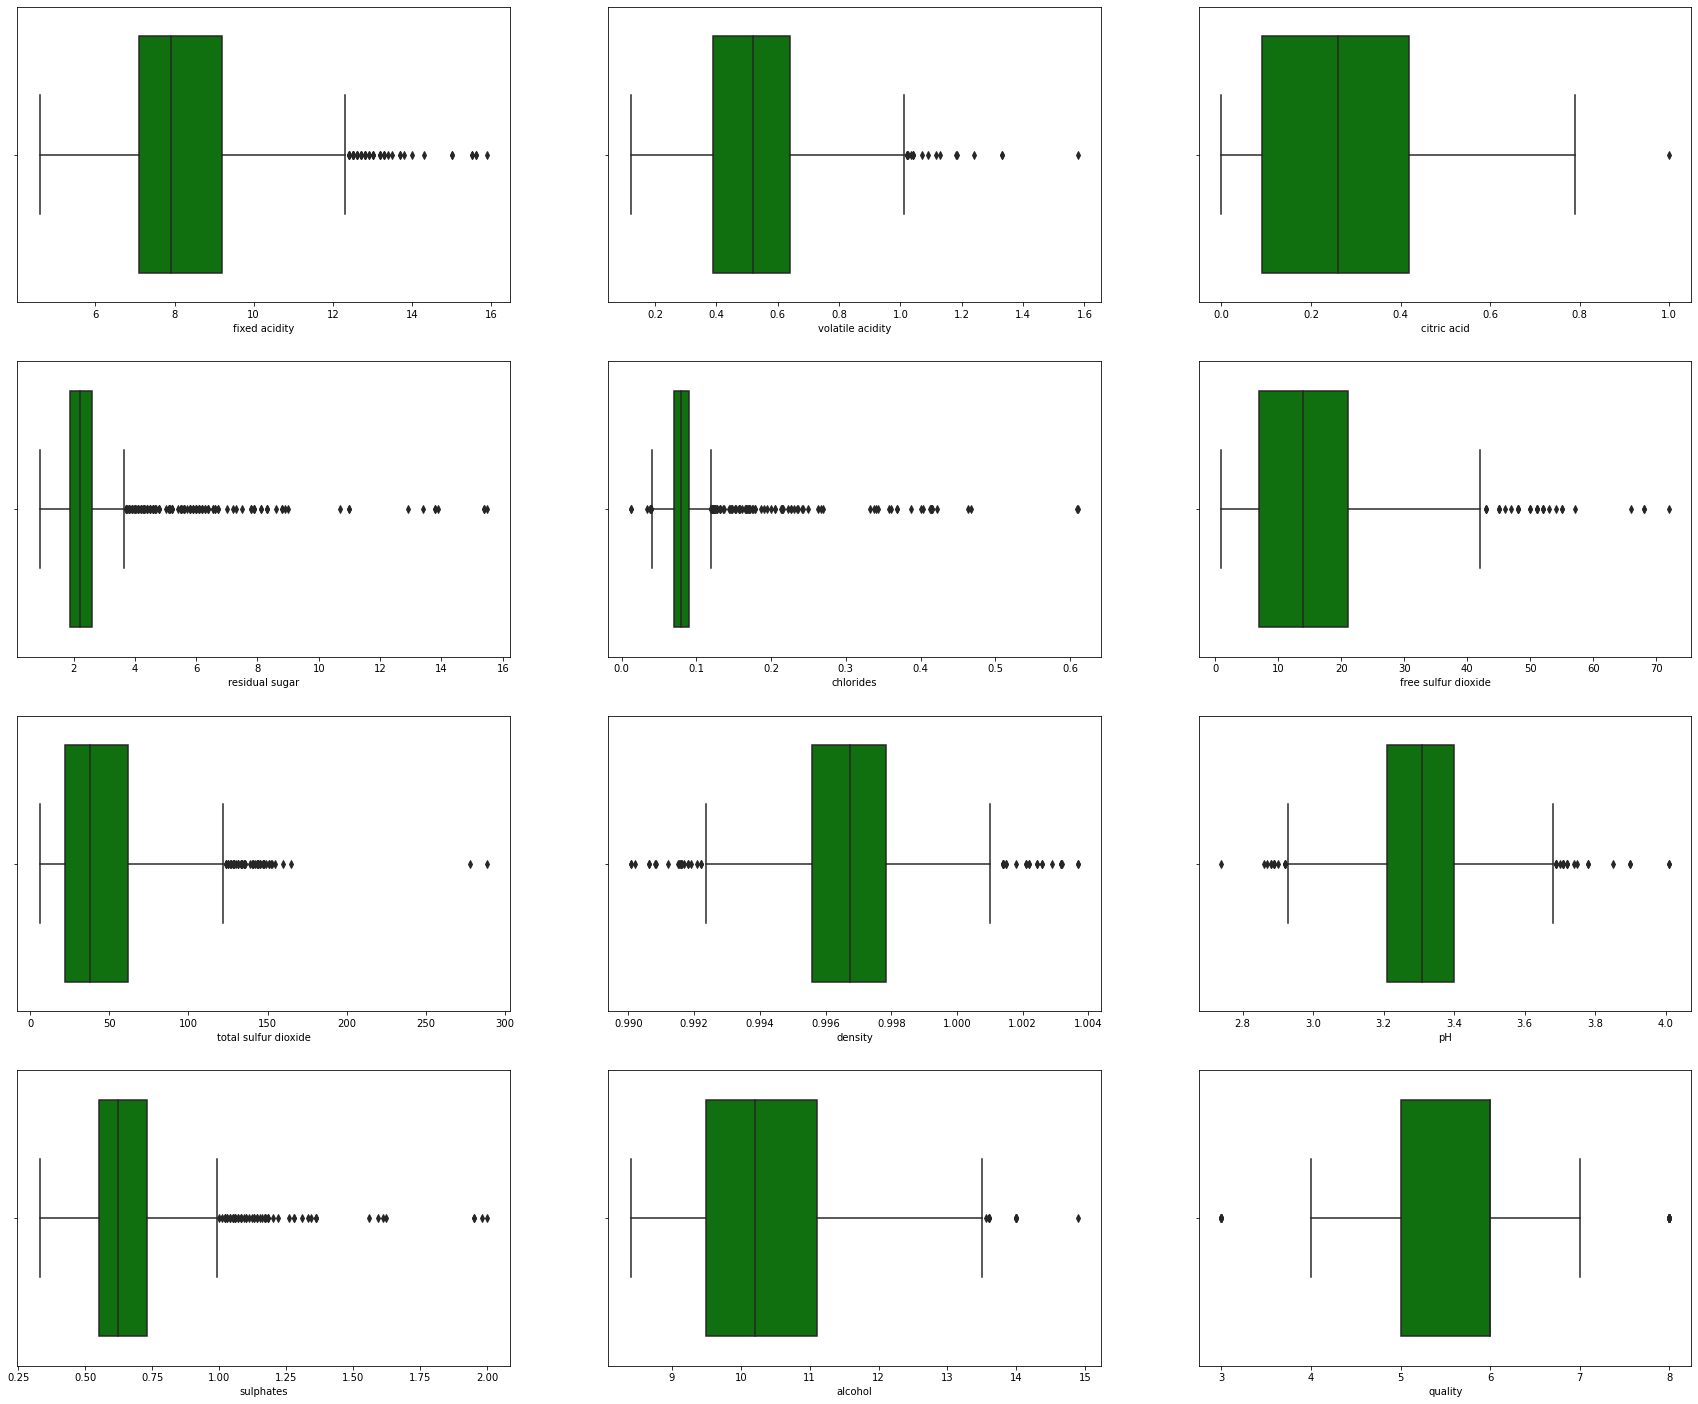

In [25]:
#checking outliers using boxplot
plt.figure(figsize=(30,25))
for i in range(0, len(columns)):
    plt.subplot(4,3, i+1)
    sns.boxplot(df[columns[i]], color='green')
print('All Features-Boxplot')
plt.show

All features have some outliers we need to remove them.

## Checking Skewness:

All Features- Distplot


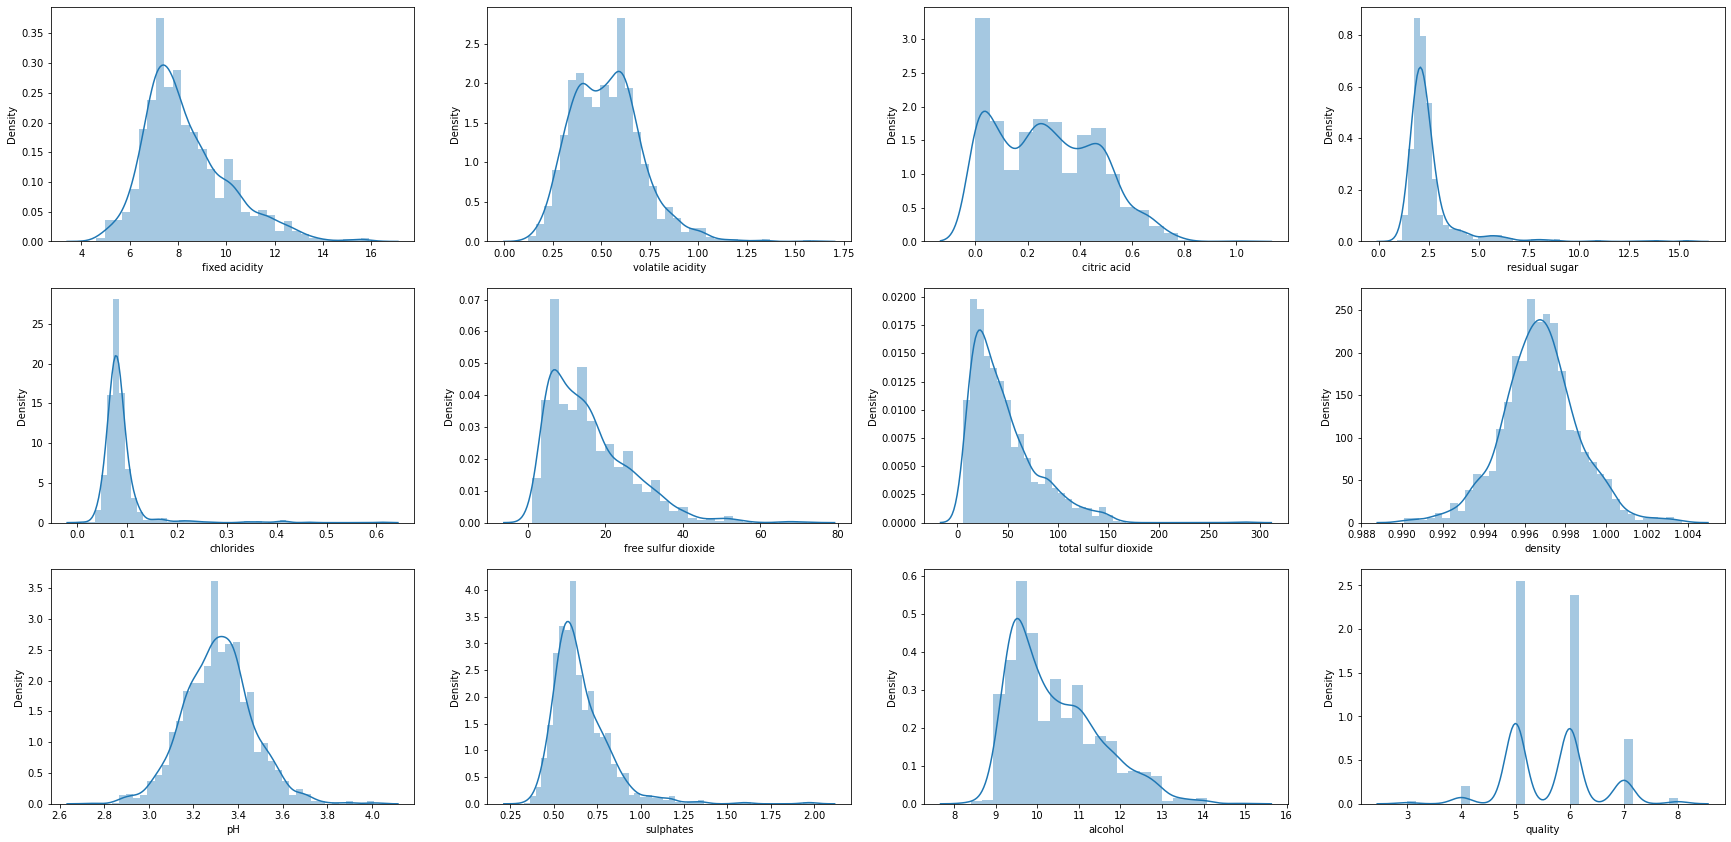

In [26]:
# checking skewness using distplot
plt.figure(figsize=(30,25))
for i in range(0, len(columns)):
    plt.subplot(5,4,i+1)
    sns.distplot(df[columns[i]])
print('All Features- Distplot')
plt.show()

The features which are giving right skewed are 'residual sugars', 'chlorides', 'sulphates', 'total sulphur dioxide', 'free sulphur dioxide'. Other data have also some skewness it can be removed by removing the outliers but still the skewness is theere then it can be removed by boxcox.

## Pairplot:

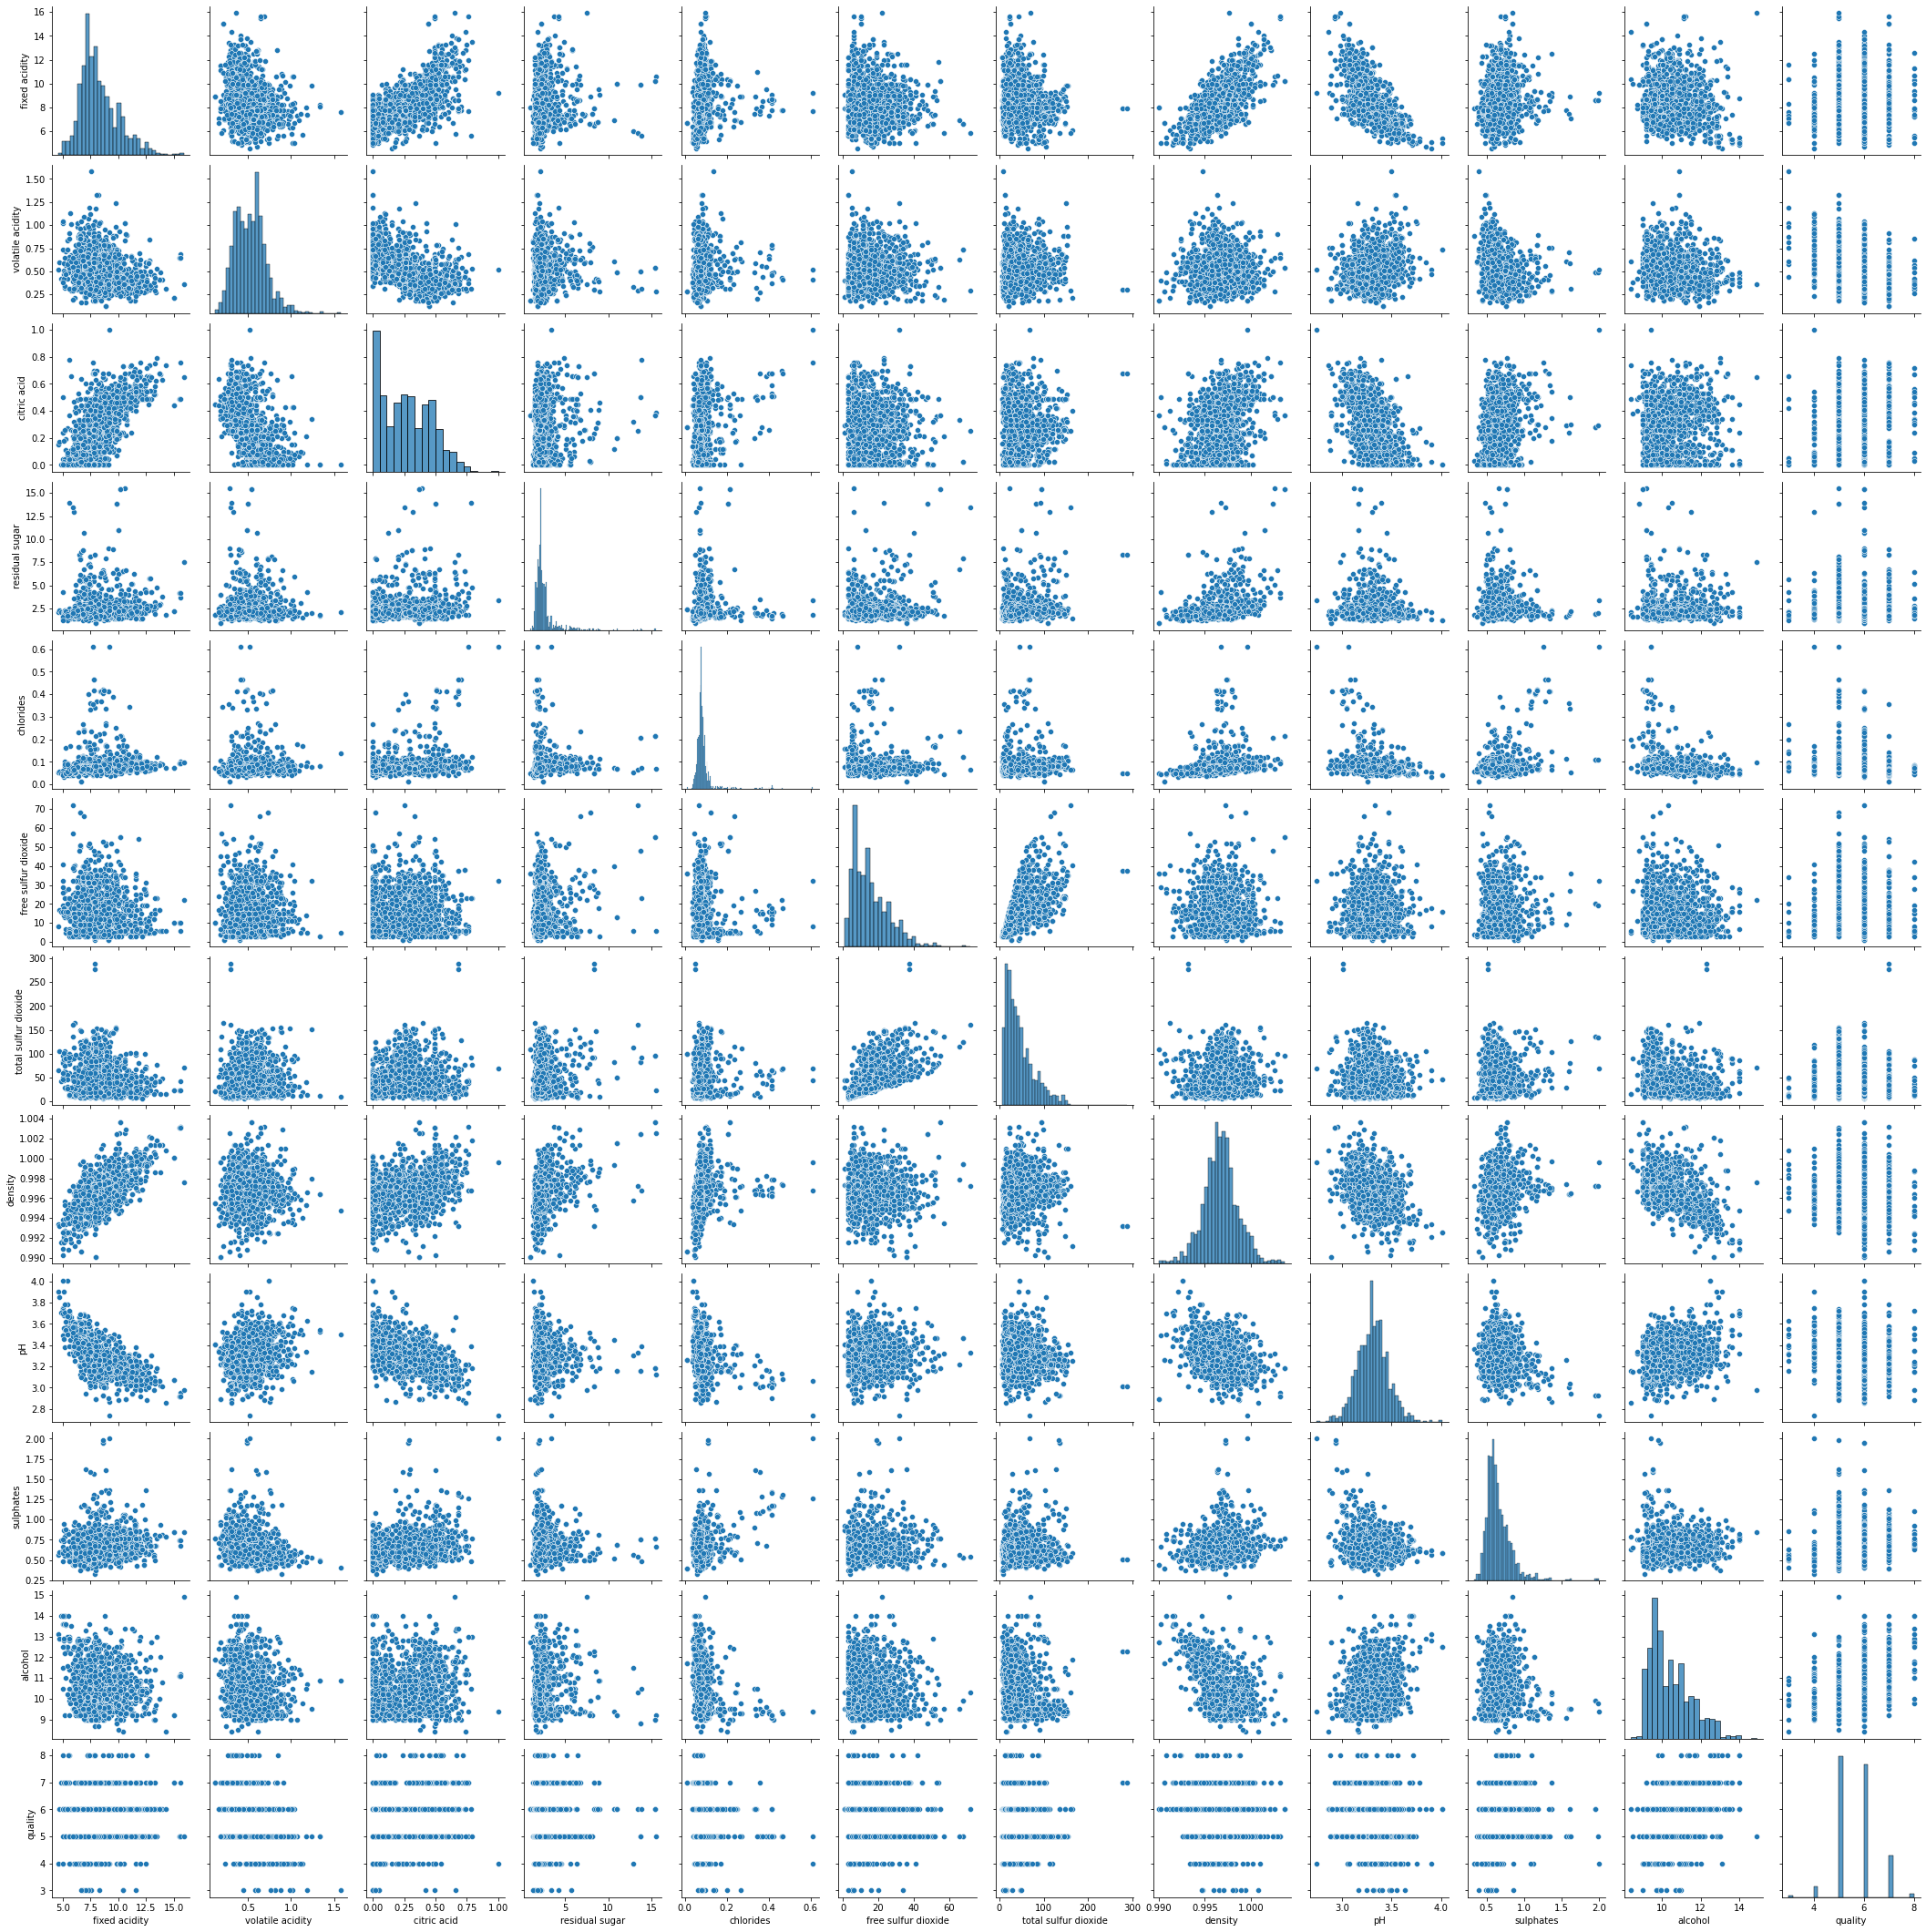

In [27]:
#visualizing data using pairplot
sns.pairplot(df)

## Removing Outliers:

In [28]:
#using zscore for removing outliers
z= np.abs(zscore(df))   #calculating absolute zscore
df_new=df[(z<4).all(axis=1)]
df_new.shape

(1537, 12)

After removing outliers we get 1451 rows from the given dataset.

## Percentage data loss:

In [35]:
loss_percent=(1599-1451)/1599*100
print(loss_percent)

9.255784865540964


## Distribution Plots:

All features-Distplot


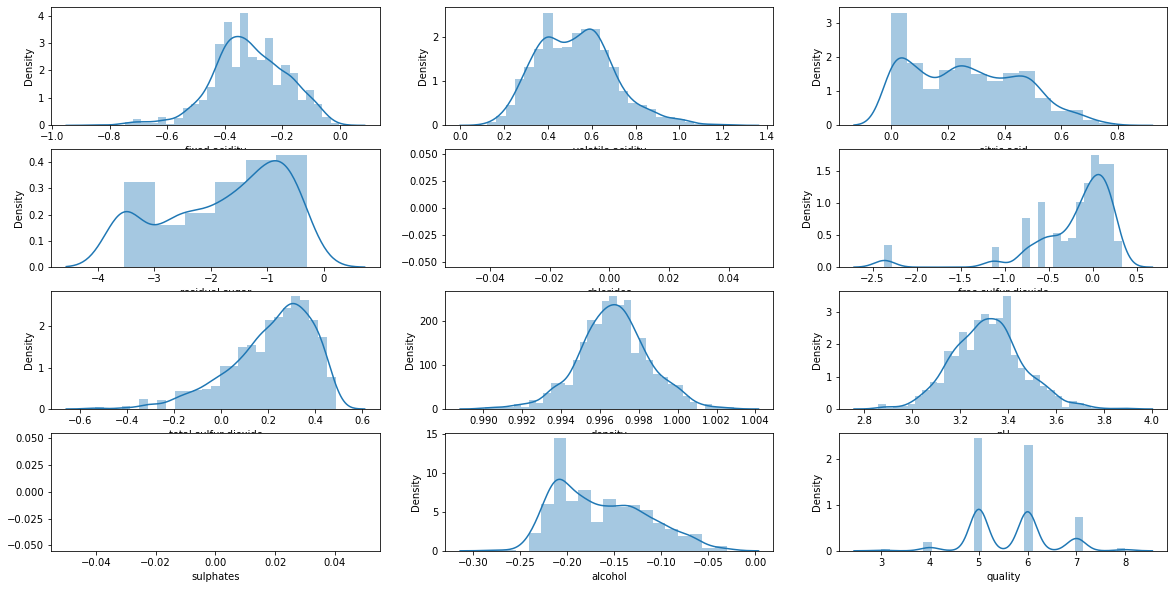

In [55]:
# visualizing all features by using distplot
plt.figure(figsize=(20,10))
for i in range(0, len(columns)):
    plt.subplot(4,3, i+1)
    sns.distplot(df_new[columns[i]])
print('All features-Distplot')
plt.show()

Features are normally distributed now and all the skewness is corrected.

## Correlation matrix:

In [56]:
#example of multivariate analysis
df_new.corr()

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.253278     0.655597   
volatile acidity          -0.253278          1.000000    -0.566741   
citric acid                0.655597         -0.566741     1.000000   
residual sugar            -0.180130          0.136964    -0.046448   
chlorides                       NaN               NaN          NaN   
free sulfur dioxide       -0.132551          0.061367    -0.111024   
total sulfur dioxide      -0.101563          0.091397    -0.042840   
density                    0.675330          0.029748     0.369562   
pH                        -0.734525          0.237415    -0.524540   
sulphates                       NaN               NaN          NaN   
alcohol                   -0.135436         -0.215699     0.132860   
quality                    0.101493         -0.389619     0.239041   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity              -0.180130        NaN            -0.132551   
volatile acidity            0.136964        NaN             0.061367   
citric acid                -0.046448        NaN            -0.111024   
residual sugar              1.000000        NaN            -0.169057   
chlorides                        NaN        NaN                  NaN   
free sulfur dioxide        -0.169057        NaN             1.000000   
total sulfur dioxide       -0.120740        NaN             0.768259   
density                     0.021656        NaN            -0.002627   
pH                          0.109828        NaN             0.116285   
sulphates                        NaN        NaN                  NaN   
alcohol                     0.063140        NaN            -0.103206   
quality                    -0.034325        NaN            -0.041523   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.101563  0.675330 -0.734525        NaN   
volatile acidity                  0.091397  0.029748  0.237415        NaN   
citric acid                      -0.042840  0.369562 -0.524540        NaN   
residual sugar                   -0.120740  0.021656  0.109828        NaN   
chlorides                              NaN       NaN       NaN        NaN   
free sulfur dioxide               0.768259 -0.002627  0.116285        NaN   
total sulfur dioxide              1.000000  0.123447  0.039166        NaN   
density                           0.123447  1.000000 -0.329001        NaN   
pH                                0.039166 -0.329001  1.000000        NaN   
sulphates                              NaN       NaN       NaN        NaN   
alcohol                          -0.241719 -0.492000  0.189723        NaN   
quality                          -0.152764 -0.181234 -0.071483        NaN   

                       alcohol   quality  
fixed acidity        -0.135436  0.101493  
volatile acidity     -0.215699 -0.389619  
citric acid           0.132860  0.239041  
residual sugar        0.063140 -0.034325  
chlorides                  NaN       NaN  
free sulfur dioxide  -0.103206 -0.041523  
total sulfur dioxide -0.241719 -0.152764  
density              -0.492000 -0.181234  
pH                    0.189723 -0.071483  
sulphates                  NaN       NaN  
alcohol               1.000000  0.487913  
quality               0.487913  1.000000

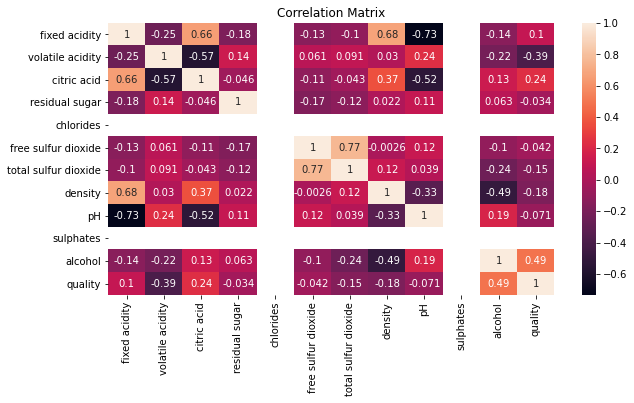

In [57]:
#visualizing correlation by heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df_new.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()


Quality of wine samples are related to 'alcohol' and 'sulphates'. 'Citric acid' and 'fixed acidity' have correlation with quality of wine. 'Total sulfur dioxide' and 'free sulfur dioxide' are correlated to each other. 'Citric acid' and 'density' are correlated with 'fixed acidity'.

## Scatter Plots:

<AxesSubplot:xlabel='alcohol', ylabel='quality'>

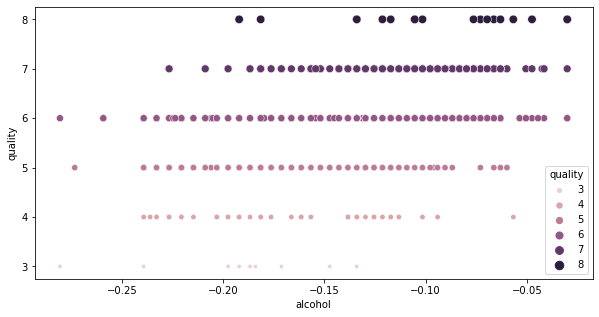

In [58]:
#Visualizing the relation between target and features using scatter plot
plt.figure(figsize=(10,5))
sns.scatterplot(x =df_new['alcohol'], y= df_new['quality'], hue = df_new['quality'],     #example of bivariate analysis
                size= df_new['quality'])

High quality wine has alcohol content 2.28 and low quality wine has alcohol content 2.19.

<AxesSubplot:xlabel='free sulfur dioxide', ylabel='total sulfur dioxide'>

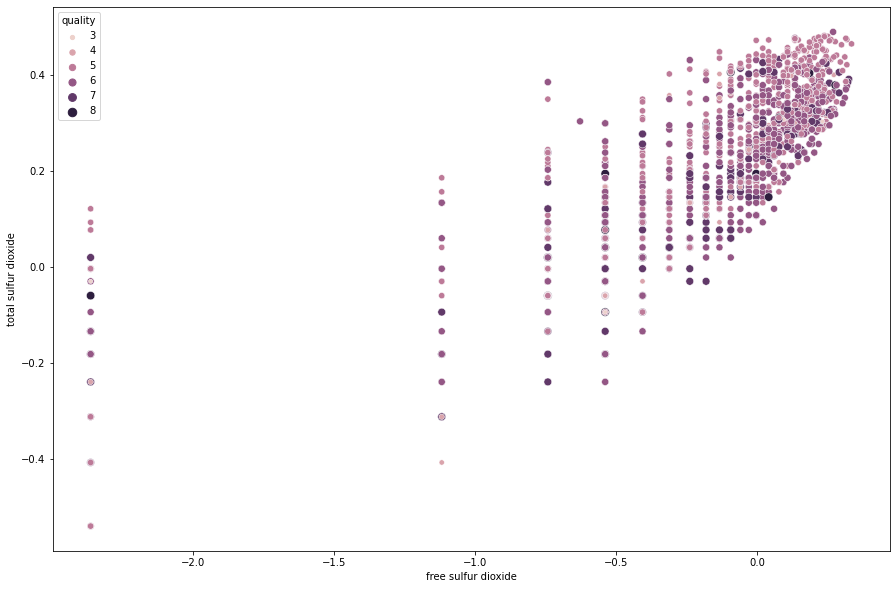

In [60]:
#visualizing relation between free sulfur dioxide and total sulfur dioxide
plt.figure(figsize=(15,10))                                           #example of bivariate analysis
sns.scatterplot(x = df_new['free sulfur dioxide'], y= df_new['total sulfur dioxide'], hue =df_new['quality'],
           size =df_new['quality'])

When free sulfur dioxide increases then total sulfur dioxide is also increases.

## Data imbalance:

<AxesSubplot:xlabel='quality', ylabel='count'>

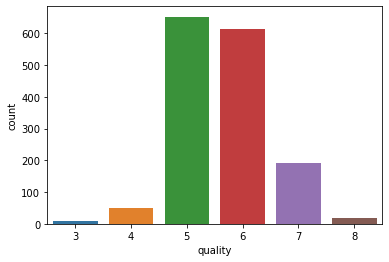

In [61]:
#visualizing the data imbalance by countplot
sns.countplot(x="quality", data= df_new)  #univariate analysis

The dataset is imbalanced and can cause overfitting.

## Dividing the dataset:

In [65]:
df["Quality"]=0
df.loc[df['quality']>7, 'Quality']=1
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Quality  
0      9.4        5        0  
1      9.8        5        0  
2      9.8        5        0  
3      9.8        6        0  
4      9.4        5        0

## Countplot:

In [66]:
##to check unique target variables & dropping the target class
df["Quality"].value_counts()
df.drop('quality', axis=1, inplace=True)

## Oversampling:

In [67]:
#splitting into attributes and target
x = df[df['Quality']==0]
y = df[df['Quality']==1]

#data balancing
upsampled = resample(y, replace=True, n_samples=x.shape[0])
df_new = pd.concat([x, upsampled])
df_new =shuffle(df_new)

The new data set has been splitted into x and y variables, x being the features and y being the target.

<AxesSubplot:xlabel='Quality', ylabel='count'>

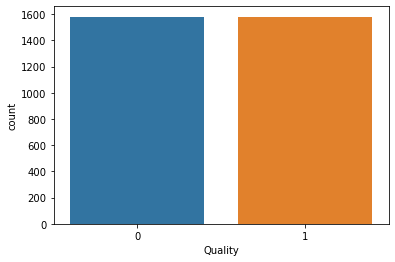

In [68]:
## To visualize the xlabel and ylabel by countplot
sns.countplot(df_new["Quality"])

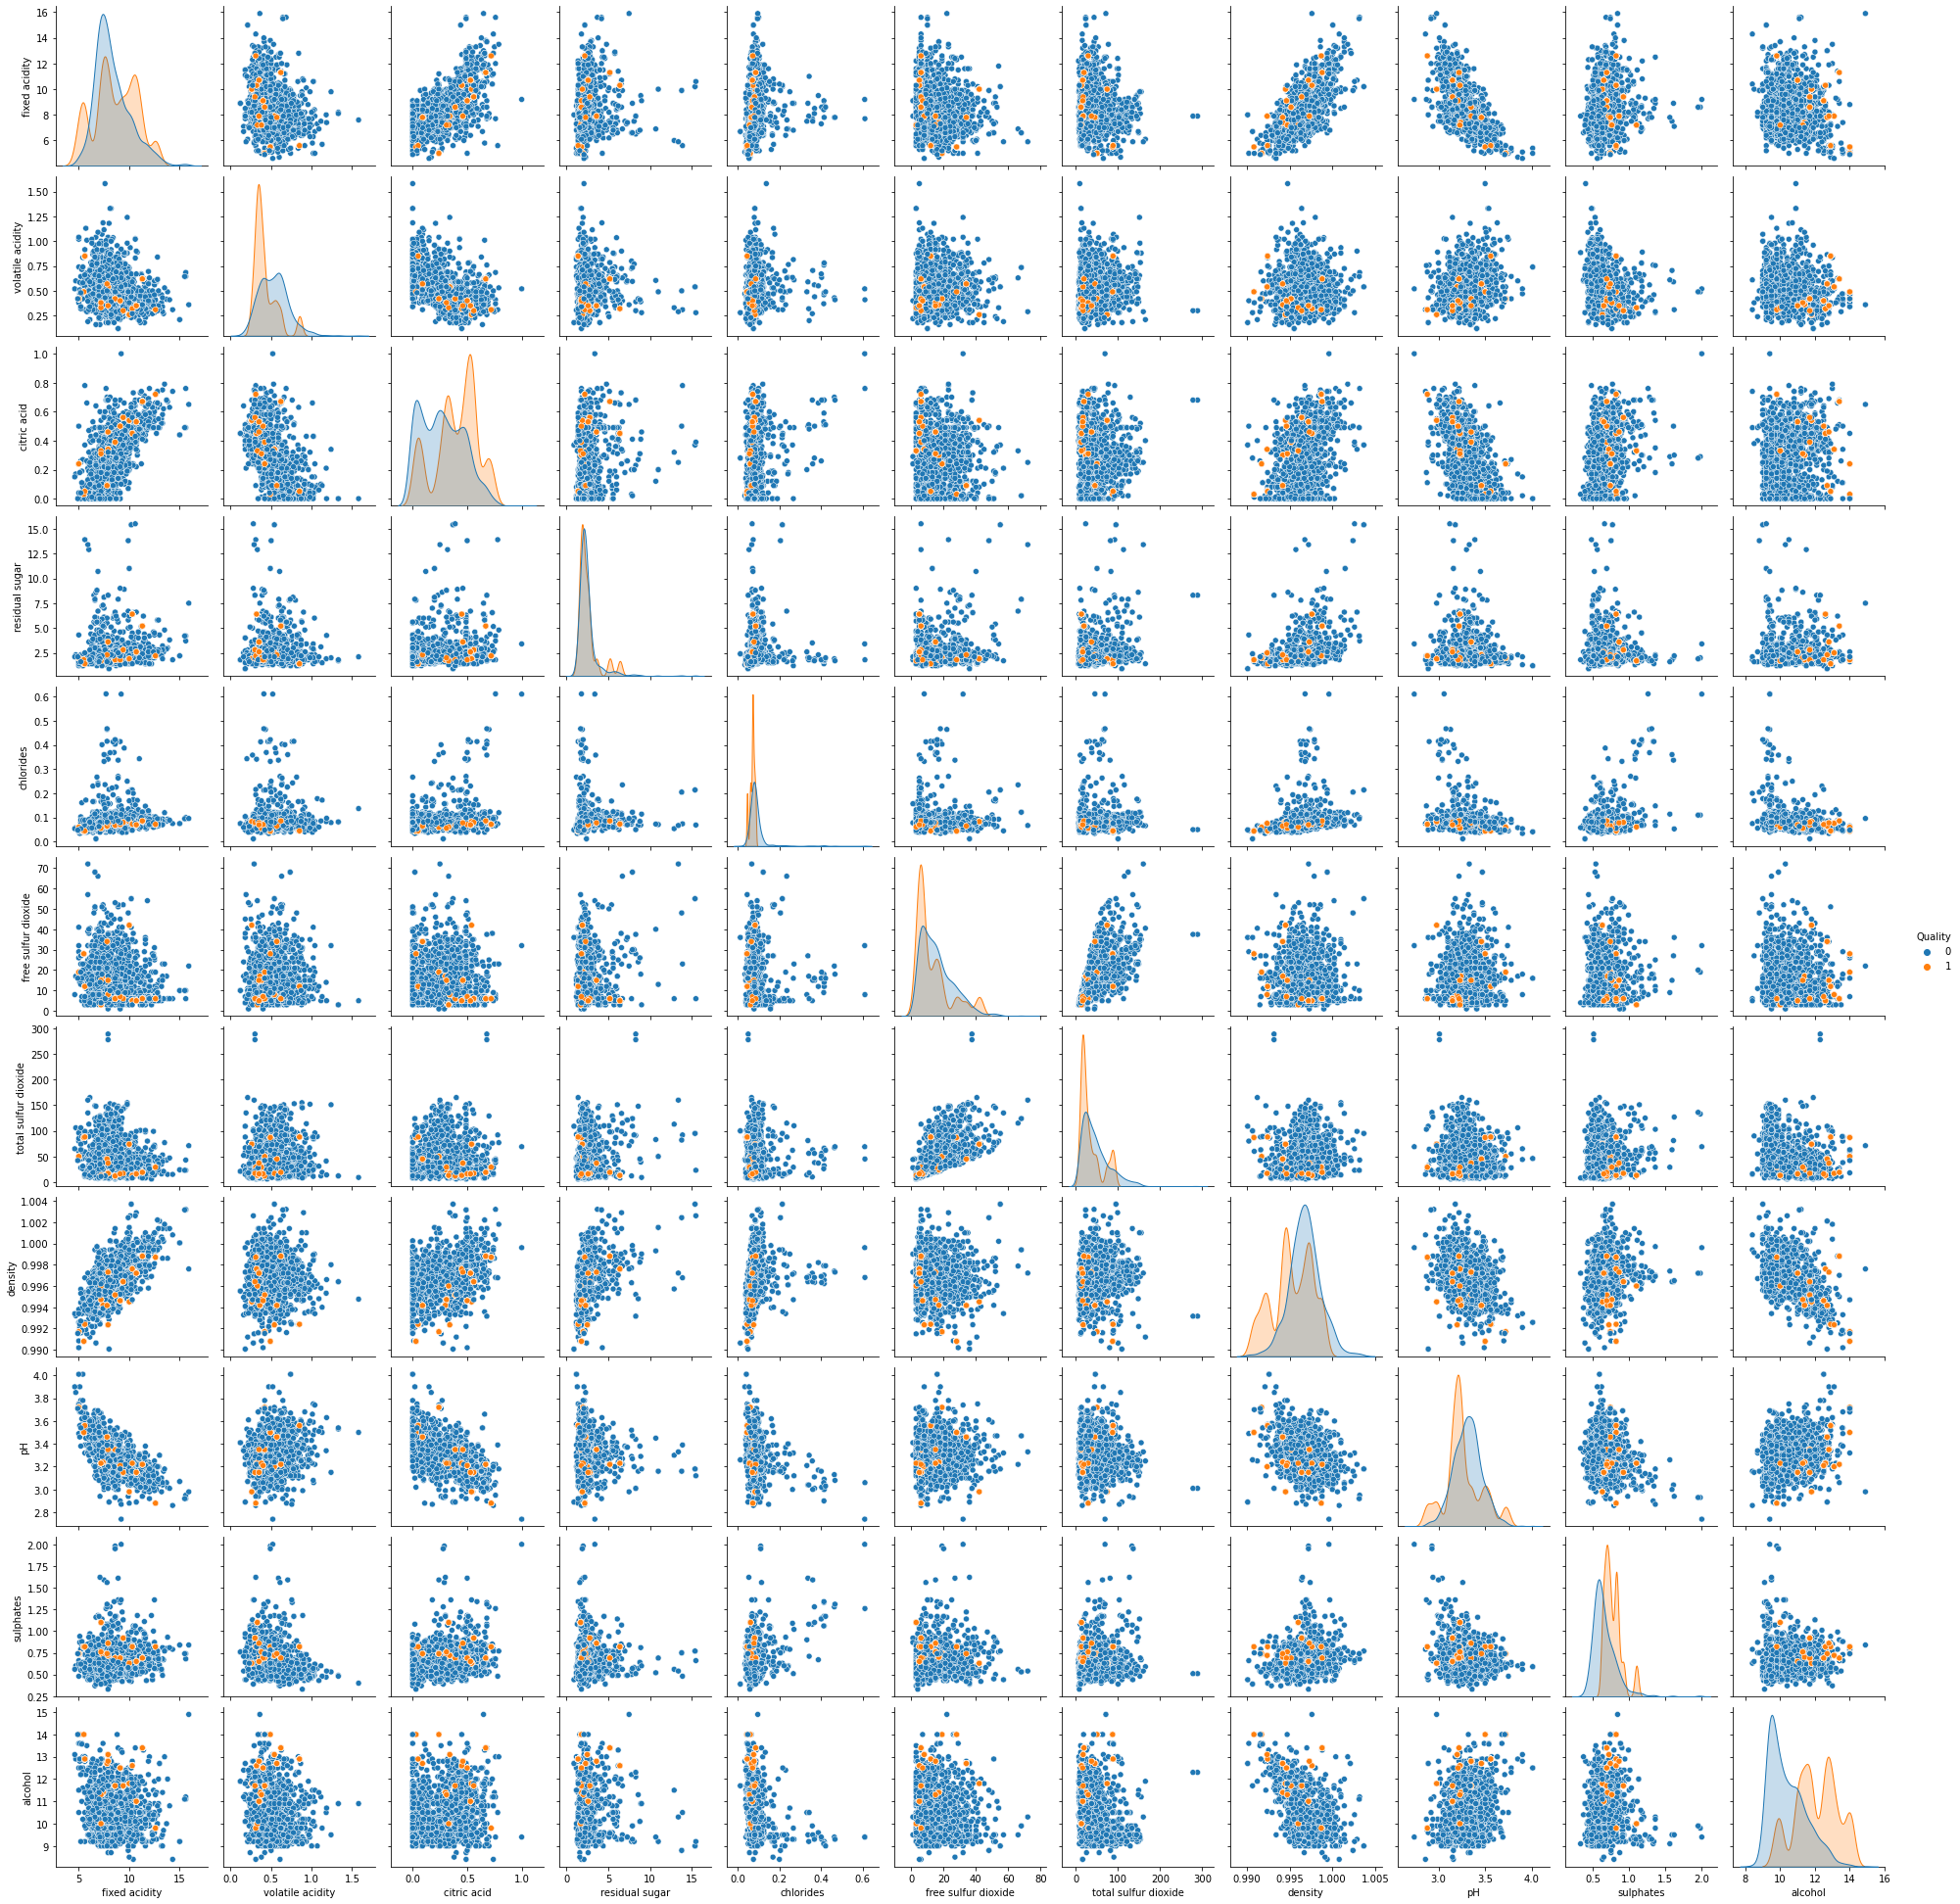

In [69]:
# Another visualization by pairplot
sns.pairplot(df_new, hue='Quality')

The data imbalanced has been removed. We can move forward for building the prediction model.

## Scaling:

In [70]:
# scaling by using train test split 
X = df_new.drop('Quality', axis=1)
y= df_new ['Quality']

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2)

In [71]:
#StandardScaler
ss =StandardScaler()
X_train =ss.fit_transform(X_train.values)
X_test=ss.fit_transform(X_test.values)
X_train=pd.DataFrame(X_train, columns= X.columns)
X_test=pd.DataFrame(X_test, columns=X.columns)
X_train.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.797951          0.443024    -0.886449       -0.258762  -0.048137   
1       0.707064          2.969908    -0.063315       -0.182752   0.008054   
2       1.485520          0.854377     1.631372        2.021538   0.232819   
3       0.499476         -1.026094     1.098756        0.197298   0.064246   
4      -0.746054          1.588936    -1.031708       -0.562801   1.019497   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.420701              0.001394  0.056791  0.684380  -0.807029   
1             1.910047              3.761677  0.893834 -0.210725  -1.529290   
2            -0.789393             -0.703659  1.246273 -0.378557  -0.150429   
3            -0.789393             -0.770807  0.188955 -0.770166   1.359752   
4             0.048364              0.807169 -0.040130 -0.378557  -0.807029   

    alcohol  
0 -0.817417  
1 -1.313974  
2  1.523493  
3  0.317569  
4 -1.243037

In [72]:
X_test.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.815603          0.649923    -0.286416        1.689108   0.152282   
1       1.110608         -0.705795     0.972270        0.027561  -0.262022   
2       0.902369         -0.882628     0.569491        2.897505  -0.179161   
3      -1.232081         -0.234241    -0.588500       -0.576638  -0.041060   
4       0.746190         -1.236293     1.022617       -0.501113   0.097042   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.271464              0.888669  0.086218  0.229742  -0.080582   
1            -0.900244             -0.826748  0.493085 -0.729240  -0.375429   
2            -0.900244             -0.923847  0.680151 -0.277954   0.627051   
3             0.536968              0.467906  0.086218  1.357957  -0.670276   
4             2.423308              1.050501 -0.764928 -1.688223  -0.493368   

    alcohol  
0 -0.113819  
1 -0.113819  
2  1.049015  
3 -1.203975  
4  0.467598

All the datatypes are of float datatype. Min-Max Scaling has been done.

In [75]:
!pip install xgboost

In [76]:
from xgboost import XGBClassifier

# Building the model

In [77]:
key = ['KNeighborsClassifier', 'RandomForestClassifier', 'GaussianNB', 'DecisionTreeClassifier', 'XGBClassifier', 'SVC']
value = [KNeighborsClassifier(), RandomForestClassifier(), GaussianNB(), DecisionTreeClassifier(), XGBClassifier(), SVC()]

models = dict(zip(key,value))

Classification Problem by selecting the classification model as KNeighborsClassifier, LogisticRegression, RandomForestClassifier, GaussianNB, DecisionTreeClassifier, XGBClassifier and SVC. We will fit the training and testing data one by one into the model and compare its accuracy.

### Model Selection:

In [78]:
training_scores=[]
testing_scores=[]

for key, value in models.items():
    value.fit(X_train, y_train)
    train_score=value.score(X_train, y_train)
    test_score=value.score(X_test, y_test)
    training_scores.append(train_score)
    training_scores.append(test_score)
    
    print(f'{key}\n')
    print(f"Training Score: {train_score}")
    print(f"Testing_score: {test_score}\n")

KNeighborsClassifier

Training Score: 0.9909054962435745
Testing_score: 0.995260663507109

RandomForestClassifier

Training Score: 1.0
Testing_score: 0.9794628751974723

GaussianNB

Training Score: 0.8402530644523527
Testing_score: 0.8593996840442338

DecisionTreeClassifier

Training Score: 1.0
Testing_score: 0.8751974723538705

[16:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier

Training Score: 1.0
Testing_score: 0.9968404423380727

SVC

Training Score: 0.9750889679715302
Testing_score: 0.9778830963665087



From the above accuracy scores. we find out that the accuracy score for the random forest classifier is highest. We need to cross validate the model to cheak the overfitting of the model. We cross validate the scoring criteria as f1-score. The model whose difference between accuracy and mean accuracy given by cross validation will be the least considered as the best model.

### Cross Validation

In [79]:
cv_scores =[]
for key, value in models.items():
    cvs=cross_val_score(value, X,y, cv=5)
    
    cv_scores.append(cvs.mean())
    print(f'{key}\n')
    print(f"CV Score: {cvs.mean()} \n")           

KNeighborsClassifier

CV Score: 0.9838652588637592 

RandomForestClassifier

CV Score: 0.9996835443037975 

GaussianNB

CV Score: 0.8421910932469453 

DecisionTreeClassifier

CV Score: 0.9949382086507889 

[16:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

Now tune the model with hyper parameter tuning. Later on we have to evaluate the model on the basis of auc score.

## Hyperparameter Tuning

### Tuning the Random Forest Classifier Model

In [83]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
pred=rfc.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.9368088467614534
[[332   0]
 [ 40 261]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       332
           1       1.00      0.87      0.93       301

    accuracy                           0.94       633
   macro avg       0.95      0.93      0.94       633
weighted avg       0.94      0.94      0.94       633



In [84]:
params = {'n_estimators': [10,100,200],
'max_depth': [10,50,100,150],
    'min_weight_fraction_leaf':[0,0.1,0.01],
        'ccp_alpha':[0,0.01,0.1]}
grid=GridSearchCV(rfc, param_grid=params, cv =5, verbose=1)

In [86]:
grid.fit(X,y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.01, 0.1],
                         'max_depth': [10, 50, 100, 150],
                         'min_weight_fraction_leaf': [0, 0.1, 0.01],
                         'n_estimators': [10, 100, 200]},
             verbose=1)

In [87]:
grid.best_params_

{'ccp_alpha': 0,
 'max_depth': 50,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 100}

Now we have got the best parameters.

## Model Evaluation

Evaluation of model using accuracy, confusion matrix and classification report.

In [88]:
#evaluation of random forest classifier
best=grid.best_estimator_
best.fit(X_train, y_train)
pred=best.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.9368088467614534
[[332   0]
 [ 40 261]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       332
           1       1.00      0.87      0.93       301

    accuracy                           0.94       633
   macro avg       0.95      0.93      0.94       633
weighted avg       0.94      0.94      0.94       633



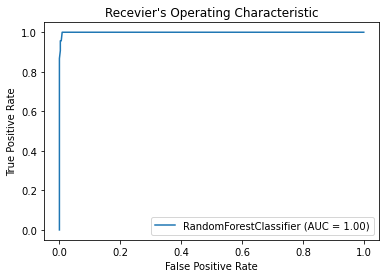

In [92]:
#AUC-ROC Curve
plot_roc_curve(best, X_test, y_test)
plt.title("Recevier's Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Serialization:

### Saving the model:

In [93]:
joblib.dump(best, "Red_Wine_Quality_Prediction_model.pkl")  #saving model as a pickle

['Red_Wine_Quality_Prediction_model.pkl']

### Conclusion

In [94]:
a=np.array(y_test)
predicted=np.array(best.predict(X_test))
df_com=pd.DataFrame({"Original":a, "Predicted":predicted}, index=range(len(a))) #creating data frame 
df_com

Original  Predicted
0           0          0
1           1          1
2           1          1
3           0          0
4           1          1
5           0          0
6           0          0
7           0          0
8           0          0
9           0          0
10          1          1
11          0          0
12          1          1
13          1          1
14          0          0
15          0          0
16          1          1
17          1          1
18          1          1
19          1          1
20          0          0
21          0          0
22          0          0
23          1          1
24          1          0
25          1          1
26          0          0
27          0          0
28          1          1
29          1          1
30          1          1
31          1          1
32          1          1
33          0          0
34          0          0
35          1          1
36          1          0
37          0          0
38          1          1
39          0          0
40          1          1
41          0          0
42          0          0
43          1          1
44          0          0
45          1          1
46          0          0
47          0          0
48          1          1
49          0          0
50          0          0
51          0          0
52          0          0
53          1          1
54          0          0
55          0          0
56          0          0
57          1          1
58          1          1
59          1          1
60          1          1
61          0          0
62          1          1
63          1          1
64          0          0
65          1          1
66          0          0
67          1          1
68          0          0
69          0          0
70          1          1
71          0          0
72          1          0
73          0          0
74          1          1
75          1          1
76          1          1
77          1          1
78          0          0
79          1          1
80          1          1
81          0          0
82          0          0
83          1          1
84          1          1
85          1          1
86          0          0
87          0          0
88          1          1
89          0          0
90          1          1
91          1          1
92          0          0
93          1          1
94          1          1
95          1          0
96          1          1
97          1          0
98          1          1
99          0          0
100         1          1
101         0          0
102         1          1
103         1          1
104         0          0
105         1          1
106         0          0
107         1          0
108         1          1
109         0          0
110         0          0
111         1          1
112         0          0
113         0          0
114         0          0
115         0          0
116         0          0
117         0          0
118         0          0
119         1          1
120         1          1
121         0          0
122         0          0
123         0          0
124         1          1
125         0          0
126         0          0
127         0          0
128         1          1
129         0          0
130         0          0
131         1          1
132         0          0
133         0          0
134         0          0
135         1          1
136         0          0
137         0          0
138         1          1
139         1          1
140         1          1
141         1          1
142         1          1
143         1          1
144         0          0
145         0          0
146         0          0
147         0          0
148         1          1
149         1          0
150         0          0
151         1          1
152         1          1
153         0          0
154         0          0
155         0          0
156         0          0
157         1          1
158         1          1
159  

### Loading the saved data:

In [95]:
mod=joblib.load('Red_Wine_Quality_Prediction_model.pkl')

Random Forest Classifier

CV Score: 0.9996835443037975 

Best model is Random Forest Classifier that we have 99.96% accuracy.